# 2.2 - Ajuste Supervisado

### GridSearching  -  CrossValidation


![grid](images/grid.png)

![cv](images/cv.ppm)

In [1]:
import warnings
warnings.simplefilter('ignore')

import numpy as np


from sklearn.datasets import make_circles, make_regression

from sklearn.model_selection import train_test_split as tts


from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import RandomForestClassifier as RFC


from sklearn.model_selection import GridSearchCV        # por fuerza bruta

In [3]:
X = make_regression()[0]

y = make_regression()[1]

In [4]:
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2, random_state=42)

In [6]:
modelo = RFR()

modelo.fit(X_train, y_train)



#R2
train_score=modelo.score(X_train, y_train)
test_score=modelo.score(X_test, y_test)

print ('Train: ',train_score)
print('Test: ', test_score)

Train:  0.8573079598944067
Test:  0.04420027789891079


In [8]:
#help(modelo)

In [9]:
params = {'n_estimators': [10, 20, 50, 100, 150, 200, 500],
          'max_depth': [5, 10, 20, 25]}

In [14]:
def grid(modelo, params):

    g = GridSearchCV(modelo,     # modelo de ML de sklearn
                     params,     # dictio de params a probar
                     cv=5,       # cv=cross-validation
                     return_train_score=True,   # error de entrenamiento
                     n_jobs=-1                  # usa todos los cores
                    )


    g.fit(X, y)

    # ajuste de todos los modelos y combinaciones
    print('Acierto test: {:.2f}'.format(g.score(X_test, y_test)))
    print('Acierto train: {:.2f}'.format(g.score(X_train, y_train)))
    print('Mejores parametros: {}'.format(g.best_params_))
    print('Mejor acierto cv: {:.2f}'.format(g.best_score_))


    return g.best_estimator_.fit(X_train, y_train)

In [15]:
%%time

modelo_grid = grid(RFR(), params)

Acierto test: 0.86
Acierto train: 0.87
Mejores parametros: {'max_depth': 20, 'n_estimators': 200}
Mejor acierto cv: -0.02
CPU times: user 844 ms, sys: 19.4 ms, total: 863 ms
Wall time: 7.73 s


In [16]:
modelo_grid.score(X_train, y_train)

0.8553210893010836

In [17]:
modelo_grid.score(X_test, y_test)

-0.014149220397838391

### Random GridSearching

In [18]:
from sklearn.model_selection import RandomizedSearchCV  # este es random

In [42]:
X, y = make_circles(noise=0.3, factor=0.5, random_state=1)

In [43]:
y[:5]

array([1, 1, 0, 1, 1])

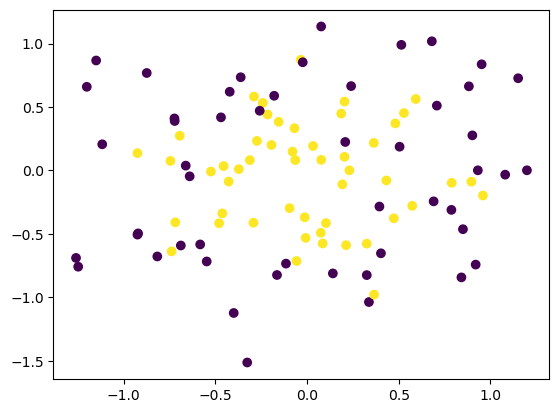

In [44]:
import pylab as plt

plt.scatter(X[::, 0], X[::, 1], c=y);

In [45]:
rfc = RFC()

In [46]:
#help(rfc)

In [47]:
n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]   # nº arboles

min_samples_split=[2, 5, 10]   # minimo de elementos para splitear

bootstrap=[True, False]  # con o sin reemplazamiento

In [48]:
params={'n_estimators': n_estimators,
        'min_samples_split':min_samples_split,
        'bootstrap': bootstrap}

In [49]:
rf_random = RandomizedSearchCV(estimator=rfc,    #modelo
                               param_distributions=params,  # dictio de params
                               
                               n_iter = 200,     # haz 200 iteraciones y coges el mejor
                               
                               cv=3,
                               verbose=0,
                               n_jobs=-1,
                               scoring='roc_auc'
                              )

In [50]:
rf_random.fit(X, y)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=200,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   scoring='roc_auc')

In [51]:
rf_random.best_score_   #R2 == 1 perfeccion

0.7711216839677046

In [52]:
rf_random.best_params_

{'n_estimators': 1000, 'min_samples_split': 10, 'bootstrap': True}

In [53]:
rf_random.best_estimator_

RandomForestClassifier(min_samples_split=10, n_estimators=1000)

In [54]:
modelo_guay = rf_random.best_estimator_.fit(X, y)

modelo_guay.score(X, y)

0.87

### HyperOpt (GridSearching bayesiano)

In [55]:
import pandas as pd

import xgboost as xgb

from sklearn.metrics import mean_squared_error as mse

from sklearn.model_selection import train_test_split as tts

In [56]:
df = pd.read_csv('../data/diamonds_train.csv')

df = df.dropna()

df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,1.21,Premium,J,VS2,62.4,58.0,4268,6.83,6.79,4.25
1,0.32,Very Good,H,VS2,63.0,57.0,505,4.35,4.38,2.75
2,0.71,Fair,G,VS1,65.5,55.0,2686,5.62,5.53,3.65
3,0.41,Good,D,SI1,63.8,56.0,738,4.68,4.72,3.00
4,1.02,Ideal,G,SI1,60.5,59.0,4882,6.55,6.51,3.95


In [57]:
X = df.drop('price', axis=1)

y = df.price

In [59]:
clarity={'I1':0, 'SI2':1, 'SI1':2, 'VS2':3, 'VS1':4,
         'VVS2':5, 'VVS1':6, 'IF':7}


cut={'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4}


color={'J':0, 'I':1, 'H':2, 'G':3, 'F':4, 'E':5, 'D':6}

In [60]:
def label(s, dic):
    
    return dic[s]

In [61]:
X.clarity = X.clarity.apply(lambda x: label(x, clarity))

X.cut = X.cut.apply(lambda x: label(x, cut))

X.color = X.color.apply(lambda x: label(x, color))

X.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,1.21,3,0,3,62.4,58.0,6.83,6.79,4.25
1,0.32,2,2,3,63.0,57.0,4.35,4.38,2.75
2,0.71,0,3,4,65.5,55.0,5.62,5.53,3.65
3,0.41,1,6,2,63.8,56.0,4.68,4.72,3.00
4,1.02,4,3,2,60.5,59.0,6.55,6.51,3.95


In [62]:
X_train, X_test, y_train, y_test = tts(X,y, test_size=0.2, random_state=42)

In [63]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32364, 9), (8091, 9), (32364,), (8091,))

In [65]:
modelo = xgb.XGBRegressor()


modelo.fit(X_train, y_train)


y_pred = modelo.predict(X_test)


mse(y_test, y_pred, squared=False)    # RMSE

546.2492119850257

In [66]:
modelo

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

In [ ]:
%pip install hyperopt

In [67]:
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK

In [69]:
# aprioris


space = {'n_estimators' : hp.quniform('n_estimators', 10, 1000, 25),
        
         'learning_rate': hp.uniform('learning_rate', 0.0001, 1.0),
         
         'max_depth': hp.quniform('max_depth', 4, 16, 1),

         'min_child_weight': hp.quniform('min_child', 1, 10, 1),

         'subsample': hp.uniform('subsample', 0.7, 1),

         'gamma': hp.uniform('gamma', 0.1, 0.5),

         'reg_lambda': hp.uniform('reg_lambda', 0, 1)
         
        }

In [78]:
def objetivo(space):
    
    modelo = xgb.XGBRegressor(n_estimators = int(space['n_estimators']),
                              
                              learning_rate = space['learning_rate'],
                              
                               max_depth = int(space['max_depth']),
                              
                              min_child_weight=space['min_child_weight'],

                              subsample=space['subsample'],

                              gamma=space['gamma'],

                              reg_lambda=space['reg_lambda'],

                              objective='reg:squarederror'
                             
                             )
    
    
    eval_set = [(X_train, y_train), (X_test, y_test)]
    
    
    modelo.fit(X_train, y_train, eval_set=eval_set, eval_metric='rmse', verbose=False)
    
    
    y_pred = modelo.predict(X_test)
    
    
    rmse = mse(y_test, y_pred, squared=False)
    
    return {'loss': rmse, 'status': STATUS_OK}
    

In [79]:
best = fmin(objetivo,             # funcion a minimizar, RMSE
            space=space,           # dictio de params
            algo=tpe.suggest,
            max_evals=10,
            trials=Trials()
           )

best

100%|██████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.53s/trial, best loss: 527.0508419818658]


{'gamma': 0.19961242982644556,
 'learning_rate': 0.1077703792051116,
 'max_depth': 10.0,
 'min_child': 9.0,
 'n_estimators': 125.0,
 'reg_lambda': 0.708725500898638,
 'subsample': 0.8015125974708511}

In [80]:
modelo = xgb.XGBRegressor(n_estimators = int(best['n_estimators']),
                              
                          learning_rate = best['learning_rate'],

                           max_depth = int(best['max_depth']),

                          min_child_weight=int(best['min_child']),

                          subsample=best['subsample'],

                          gamma=best['gamma'],

                          reg_lambda=best['reg_lambda'],

                          objective='reg:squarederror'

                         )


In [81]:
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)
    
mse(y_test, y_pred, squared=False)

527.0508419818658

In [82]:
m = xgb.XGBRegressor()

m.fit(X_train, y_train)

y_pred = m.predict(X_test)
    
mse(y_test, y_pred, squared=False)

546.2492119850257